## Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 4: Régularisation

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import poutyne as pt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from deeplib.datasets import load_cifar10, load_mnist, train_valid_loaders
from deeplib.net import CifarNet, CifarNetBatchNorm
from deeplib.training import train, test

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

cifar_train, cifar_test = load_cifar10()
mnist_train, mnist_test = load_mnist()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Files already downloaded and verified
Files already downloaded and verified


## 1. Régularisation L1 et L2

### Implémentation manuelle
La régularisation L2 est communément appelée **weight decay**. Dans PyTorch, les optimiseurs de `torch.optim` ont un paramètre `weight_decay` pour facilement utiliser cette régularisation. Par contre, on peut facilement implémenter manuellement la régularisation L2 comme une pénalité sur la norme des poids (voir le [chapitre 7.1](http://www.deeplearningbook.org/contents/regularization.html)).

#### Exercice
Complétez la fonction *loss_init* en ajoutant manuellement la pénalité sur les paramètres du réseau selon une régularisation L1 ou L2. Le paramètre *reg_alpha* correspond à l'hyperparamètre de régularisation $\alpha$ du livre ($\lambda$ dans les acétates du cours). Le paramètre *p* correspond à l'ordre de la norme: $p=1$ pour la norme L1 et $p=2$ pour la norme L2.

In [ ]:
def loss_init(parameters=[], reg_alpha=0, p=2):
    cross_entropy = nn.CrossEntropyLoss()
    
    def loss_function(output, targets):
        loss = cross_entropy(output,targets)
        
        for param in parameters:
            # TODO
            loss += reg_alpha/p * torch.norm(param, p=p) ** p
        
        return loss
    return loss_function

Testez votre implémentation de la régularisation par la norme L2 ($p=2$):

In [ ]:
torch.manual_seed(42)
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(net.parameters(), reg_alpha=1e-3, p=2)

train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

Testez votre implémentation de la régularisation par la norme L1 ($p=1$):

In [ ]:
torch.manual_seed(42)
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(net.parameters(), reg_alpha=1e-3, p=1)

train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

### Utilisation du *weight decay*

Explorons maintenant l'utilisation du paramètre `weight_decay` disponible dans les optimiseurs de `PyTorch` pour effectuer de la régularisation L2. Nous allons entrainez un réseau de neurones avec régularisation L2 et un autre sans pour pouvoir observer l'impact de la régularisation sur l'apprentissage et le réseau appris.

In [ ]:
# Paramètres
batch_size = 64
lr = 0.1
n_epoch = 15

Réseau sans régularisation L2:

In [ ]:
torch.manual_seed(42)
net_without_l2 = CifarNet()
optimizer_without_l2 = optim.SGD(net_without_l2.parameters(), lr=lr, weight_decay=0)

history_without_l2 = train(net_without_l2, optimizer_without_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_without_l2.display()
print('Précision en test: {:.2f}'.format(test(net_without_l2, cifar_test, batch_size=64)))

Réseau avec régularisation L2 (*weight decay*):

In [ ]:
weight_decay = 1e-3

torch.manual_seed(42)
net_l2 = CifarNet()
optimizer_l2 = optim.SGD(net_l2.parameters(), lr=lr, weight_decay=weight_decay)

history_l2 = train(net_l2, optimizer_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_l2.display()
print('Précision en test: {:.2f}'.format(test(net_l2, cifar_test, batch_size=64)))

#### Questions
- Quel est l'effet de la régularisation L2 sur l'entraînement du réseau? **Au niveau de l'accuracy, on remarque que les performances en validation et en test sont légèrement meilleures. Également, l'utilisation de la régularisation réduit le surapprentissage. En effet l'écart des valeurs d'accuracy et de loss entre l'entraînement et la validation est nettement moins important (voir graphiques)**
- Si vous utilisez un weight_decay trop grand (exemple 0.1) qu'arrive-t-il? Pourquoi? **Le réseau ne parvient tout simplement pas à apprendre car la pénalité sur les poids est trop importante.**

Dans la cellule suivante, analysez avec un histogramme la distribution des poids appris par les réseaux avec ou sans régularisation. 

- Que remarquez-vous? **Avec la régularisation L2, les poids appris sont plus concentrés près de 0.**

In [ ]:
def net_to_weight_array(net):
    weights = []
    for p in net.parameters():
        p_numpy = p.data.cpu().numpy()
        weights.append(p_numpy.reshape((-1))) # Reshape to 1D array
    return np.concatenate(weights)

weights_without_l2 = net_to_weight_array(net_without_l2)
weights_l2 = net_to_weight_array(net_l2)

# Visualisation
plt.hist(weights_without_l2, bins='auto', range=(-0.3, 0.3), alpha =0.5, label="Sans régularisation L2")
plt.hist(weights_l2, bins='auto', range=(-0.3, 0.3), alpha=0.5, label="Avec régularisation L2")
plt.legend()
plt.show()

## 2. Early stopping

Commencez par entraîner un réseau pour un grand nombre d'époques. L'historique d'entraînement nous servira de base pour les questions qui suivent.

In [16]:
torch.manual_seed(42)
net = CifarNetBatchNorm()

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-3, nesterov=True, momentum=0.9)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=3, factor=0.5, verbose=True)

history = train(net, optimizer, cifar_train, n_epoch=40, batch_size=64, callbacks=[scheduler], use_gpu=True)

Epoch: 1/40 Step: 625/625 100.00% |█████████████████████████|7.70s loss: 1.584498 acc: 45.472500 val_loss: 1.304358 val_acc: 52.910000
Epoch: 2/40 Step: 625/625 100.00% |█████████████████████████|7.73s loss: 1.166914 acc: 58.532500 val_loss: 1.147053 val_acc: 59.440000
Epoch: 3/40 Step: 625/625 100.00% |█████████████████████████|7.83s loss: 0.986132 acc: 65.415000 val_loss: 1.139814 val_acc: 60.000000
Epoch: 4/40 Step: 625/625 100.00% |█████████████████████████|7.59s loss: 0.863612 acc: 70.152500 val_loss: 1.039746 val_acc: 63.450000
Epoch: 5/40 Step: 625/625 100.00% |█████████████████████████|7.76s loss: 0.781362 acc: 72.885000 val_loss: 0.996133 val_acc: 65.580000
Epoch: 6/40 Step: 625/625 100.00% |█████████████████████████|7.92s loss: 0.713632 acc: 75.445000 val_loss: 1.040272 val_acc: 63.480000
Epoch: 7/40 Step: 625/625 100.00% |█████████████████████████|7.71s loss: 0.652623 acc: 77.572500 val_loss: 0.917152 val_acc: 68.510000
Epoch: 8/40 Step: 625/625 100.00% |████████████████████

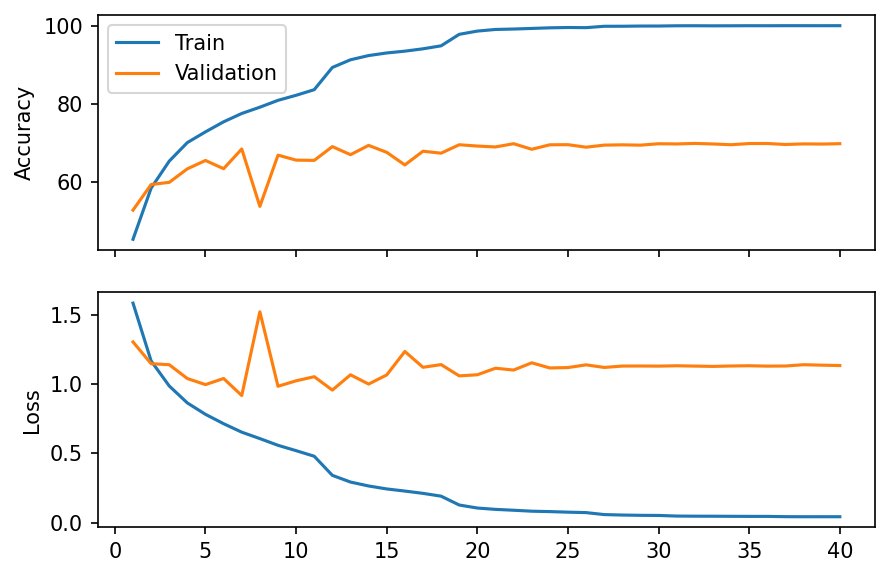

In [17]:
history.display()

#### Question
- En regardant les graphiques ci-dessus, quel est le meilleur moment pour arrêter l'entraînement? **Autour de l'époque 20 la précision en validation semble la plus élevée et commence à être stable.**

L'algorithme 7.1 du livre (voir http://www.deeplearningbook.org/contents/regularization.html page 244) décrit le paramètre de patience `p` dans le contexte d'un algorithme de *early stopping*.

#### Exercice
Analysez l'effet du choix de `p` sur les données de l'entraînement précédent. Regardez pour `p = 1,2,5,10,15`, quelle époque avec quelle précision en validation est choisie. Implémentez un algorithme effectuant du *early stopping* en utilisant l'historique `val_accuracy` de l'entraînement que vous venez d'exécuter pour vos tests (à la place d'entraîner le réseau).

In [39]:
# Historique
val_accuracy_history = history.history['val_acc']

# Patience
p = 5

best_val_accuracy = -np.inf
best_epoch = -1

# TODO
counter = 0
for epoch, val_accuracy in enumerate(val_accuracy_history):
    # Amélioration de la précision en validation
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        counter = 0
    # On patiente ...
    else:
        counter += 1
        if counter == p:
            break
# TODO END
            
print("Meilleure époque {}, avec précision en validation de {:.2f}.".format(best_epoch, best_val_accuracy))

Meilleure époque 21, avec précision en validation de 69.86.


#### Question

- Identifiez des problèmes pratiques potentiels lors de l'utilisation du *early stopping*. **Il est difficile de sélectionner la bonne valeur de patience. Une valeur trop faible arrête l'entraînement trop tôt ce qui peut résulter en un modèle avec de moins bonnes performances, alors qu'une valeur trop élévée de patience peut nous obliger à calculer un nombre d'époques plus important que necessaire (temps)**

## 3. Dropout
Cette section a pour but d'analyser l'effet du dropout dans un réseau fully connected. Nous ferons cette analyse en reprenant l'exercice du laboratoire 2.


In [ ]:
dataset, _ = load_mnist()

#### Exercice
Dans le réseau suivant, implémentez la fonction `forward()` en ajoutant du dropout si `self.use_dropout == True`. N'ajoutez **pas de softmax** car la fonction `deeplib.training.train()` utilise par défaut `CrossEntropyLoss`, ce qui le fait pour vous. Utilisez une probabilité de drop de `0.4`. Ne faites pas de dropout sur la couche de sortie.

> **ATTENTION!** Vous devez bien fixer l'argument `training` de dropout. Vous pouvez savoir si modèle est en entraînement ou en évaluation avec self.training.

### Question
- Quelle est l'importance de l'argument `training` de la fonction de dropout?

In [ ]:
class MnistModel(torch.nn.Module):
    
    def __init__(self, n_layers, hidden_size=100, use_dropout=True):
        super().__init__()
        torch.manual_seed(12345)
        self.use_dropout = use_dropout
        self.hidden_size = hidden_size
        
        layer_sizes = [28*28] + [self.hidden_size]*n_layers
        self.layers = nn.ModuleList()
        for input_size, output_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer = nn.Linear(input_size, output_size)
            layer.weight.data.normal_(0.0, math.sqrt(2 / input_size))
            layer.bias.data.fill_(0.0001)
            self.layers.append(layer)
            
        self.output_layer = nn.Linear(hidden_size,10)
        self.output_layer.weight.data.normal_(0.0, math.sqrt(2 / hidden_size))
        self.output_layer.bias.data.fill_(0.0001)              

    def forward(self, x):
        out = x.view(-1, 28*28)
        pass
        #TODO

Entraînez un réseau avec dropout et un réseau sans dropout.

In [ ]:
net = MnistModel(2, use_dropout=False)
net_dropout = MnistModel(2, use_dropout=True)
net.cuda()
net_dropout.cuda()

optimizer = optim.SGD(net.parameters(), lr=0.005, nesterov=True, momentum=0.9)
optimizer_dropout = optim.SGD(net_dropout.parameters(), lr=0.005, nesterov=True, momentum=0.9)

history = train(net, optimizer, dataset, 20, batch_size=64)
history_dropout = train(net_dropout, optimizer_dropout, dataset, 20, batch_size=64)

In [ ]:
history.display()

In [ ]:
history_dropout.display()

#### Exercice
- Essayez plusieurs valeurs de dropout et observez les effets.
- Essayer d'avoir des valeurs différentes de probabilité de dropout pour chaque couche. Est-ce que cela améliore les résultats?